In [64]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow import keras

In [65]:
#https://www.kaggle.com/c/bike-sharing-demand/data
dcpd = pd.read_csv("dc_bike_share_train.csv", parse_dates=["datetime"], index_col="datetime")

In [66]:
#keep 90% of the data for train. If you use validation steps, make it 80%
train_size = int(len(dcpd) * 0.9)
train, test = dcpd.iloc[0:train_size], dcpd.iloc[train_size: int(len(dcpd))]

In [67]:
#copy the original dataframe to apply prediction
dcpd_copy = dcpd
print(train.shape, test.shape)

(9797, 11) (1089, 11)


Data Fields definition:
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

In [68]:
dcpd.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [69]:
#It uses the interquartile range, so that it is robust to outliers. Focuses on area of bulk data
scaler = RobustScaler()
columns_scaled = ["temp","atemp","humidity","windspeed","casual","registered"]

x_scaled = scaler.fit(train[columns_scaled].to_numpy())
y_scaled = scaler.fit(train[["count"]])

train.loc[:,columns_scaled] = x_scaled.transform(train[columns_scaled].to_numpy())
train["count"] = scaler.transform(train[["count"]])

test.loc[:,columns_scaled] = x_scaled.transform(test[columns_scaled].to_numpy())
test["count"] = scaler.transform(test[["count"]])

In [70]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-10-12 14:00:00,4,0,1,1,-0.491695,-0.476631,-0.432203,-0.457623,-0.127119,0.521186,0.983051
2012-10-12 15:00:00,4,0,1,1,-0.498644,-0.483051,-0.411017,-0.461853,-0.004237,0.754237,1.338983
2012-10-12 16:00:00,4,0,1,1,-0.509068,-0.492691,-0.415254,-0.487291,-0.131356,1.156780,1.614407
2012-10-12 17:00:00,4,0,1,1,-0.509068,-0.492691,-0.427966,-0.478802,-0.033898,2.402542,2.957627
2012-10-12 18:00:00,4,0,1,1,-0.512542,-0.495890,-0.427966,-0.504239,-0.266949,1.809322,2.131356


In [71]:
#Always create batches of dataset with 3D array of inputs as needed by LSTM (Long Short Term Memory) / GRU
def createdataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i+time_steps)].to_numpy()
        Xs.append(v)
        w = y.iloc[i: (i+time_steps)].to_numpy()
        ys.append(w)
    return np.array(Xs), np.array(ys)

In [72]:
# Since there are 24 hours in the bikeshare dataset, set the timeseries to 24
prior_time_stamp = 24
X_train, y_train = createdataset(train, train["count"], time_steps = prior_time_stamp)
X_test, y_test = createdataset(test, test["count"], time_steps = prior_time_stamp)

In [73]:
# It is important to check the shape of the dataset after every process
X_train.shape, y_train.shape

((9773, 24, 11), (9773, 24))

In [74]:
# BiDirectional with GRU. Similar to LSTM. Input shape should be the (,24,11) as the first dimension is the count of rows
# 20% Dropout and units=24 for the timesteps that needs to be predicted at once in the ouput layer
model = keras.Sequential()
model.add(keras.layers.Bidirectional
          (keras.layers.GRU(units=128,input_shape=(X_train.shape[1],X_train.shape[2])
     )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=24))

In [75]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=30, batch_size= 32, validation_split=0.1, shuffle=False, verbose=0)

In [76]:
#save the model for future use. Uncomment the line below to save
model.save("GRU-24-timestep.h5")

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection multiple                  108288    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  6168      
Total params: 114,456
Trainable params: 114,456
Non-trainable params: 0
_________________________________________________________________


In [78]:
#Load the model for future use. Uncomment the line below to use
#model = keras.models.load_model("GRU-24-timestep.h5")

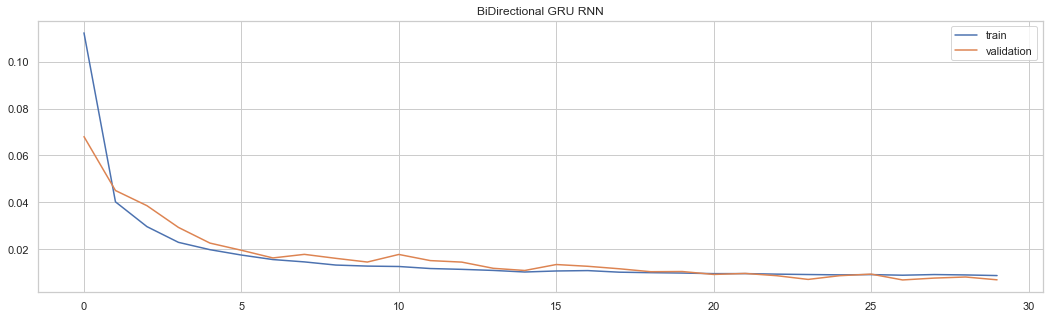

In [79]:
#Observe that with earlystopping, you can setup the epochs = 15 for optimal performance
plt.figure(figsize=(18,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('BiDirectional GRU RNN')
plt.legend()

In [80]:
#Create test dataset batches to compare test vs prediction

In [81]:
print(X_test.shape, y_test.shape)

(1065, 24, 11) (1065, 24)


In [82]:
y_pred = model.predict(X_test)

In [83]:
y_pred.shape

(1065, 24)

In [84]:
#Calculate the MSE, the lower the better. This shows a poc for the metric. In reality you need to inverse transform
#Applying inverse transform which gives us re-scaled data, MSE may be high. You will need to fine tune the model
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.0058334656

In [85]:
#Get the real values by applying inverse transform to the RobustScaler
y_test = scaler.inverse_transform(y_test)
y_pred1 = scaler.inverse_transform(y_pred)

In [86]:
print(y_test.shape, y_pred1.shape)

(1065, 24) (1065, 24)


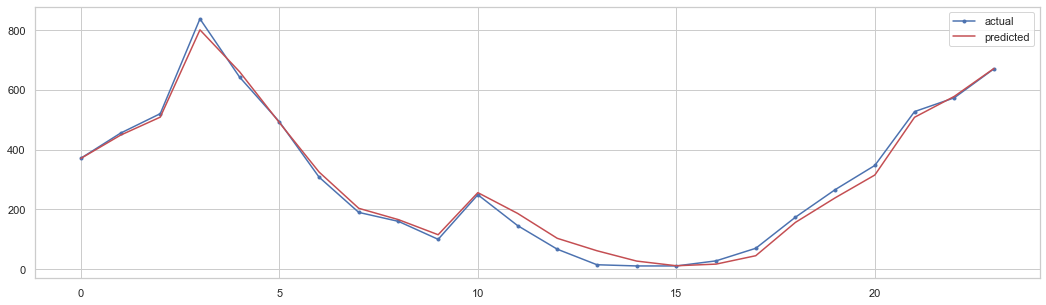

In [87]:
#Present the first batch for comparison of test vs. predictions. Though the values appear close, futher tuning is needed
plt.figure(figsize=(18,5))
plt.plot(y_test[0], marker='.', label='actual')
plt.plot(y_pred1[0], 'r', label='predicted')
plt.legend()

# Predict the future 24 timesteps and plot the last 24 steps with future 24 steps

In [88]:
#Take 1 value from the past to predict 24 in the future. Code can be further cleaned up
#by creating a new function to pass last 24 predicted values to capture new 24 / future 24 lines
X = X_test[-1:]
y_pred_new = model.predict(X)

In [89]:
y_pred_new = scaler.inverse_transform(y_pred_new)
y_test_new = scaler.inverse_transform(y_test)

In [90]:
y_pred_reshape = y_pred_new.reshape(-1,1)

In [91]:
print(y_pred_reshape.shape)

(24, 1)


In [92]:
#Calculate a dataframe with the future 24 timesteps December 20, for 24 hours
from pandas.tseries.offsets import DateOffset
df = dcpd_copy
add_dates = [df.index[-1] + DateOffset(hours=x) for x in range(0,25)]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [93]:
df_predict = pd.DataFrame(y_pred_reshape,index=future_dates[-24:].index, columns=['Prediction'])

In [94]:
df_predict.head()

,Prediction
2012-12-20 00:00:00,75.736572
2012-12-20 01:00:00,23.135208
2012-12-20 02:00:00,30.167915
2012-12-20 03:00:00,22.625137
2012-12-20 04:00:00,12.697693


In [95]:
df_proj = pd.concat([dcpd_copy, df_predict], axis=1)

In [96]:
df_proj.tail(25)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Prediction
2012-12-19 23:00:00,4.0,0.0,1.0,1.0,-0.53339,-0.518369,66.0,-0.550856,4.0,84.0,88.0,NaN
2012-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.736572
2012-12-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.135208
2012-12-20 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.167915
2012-12-20 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.625137
2012-12-20 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.697693
2012-12-20 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.166893
2012-12-20 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.182320
2012-12-20 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.831879
2012-12-20 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377.502350


In [97]:
#capture the last 24 lines of data with "Count" i.e. column # 10
df_act_final =df_proj.iloc[-48:-24, 10]
#Preview the last 5 lines to show the time period of 12/19
df_act_final.tail()

2012-12-19 19:00:00    336.0
2012-12-19 20:00:00    241.0
2012-12-19 21:00:00    168.0
2012-12-19 22:00:00    129.0
2012-12-19 23:00:00     88.0
Name: count, dtype: float64

In [98]:
#Capture the last 24 lines of predicted data. 
#You can further simplify these two steps with an addition ("Count + Pred")
df_pred_final =df_proj.iloc[-24:, 11]
df_pred_final.head()

2012-12-20 00:00:00    75.736572
2012-12-20 01:00:00    23.135208
2012-12-20 02:00:00    30.167915
2012-12-20 03:00:00    22.625137
2012-12-20 04:00:00    12.697693
Name: Prediction, dtype: float32

Text(0.5, 1.0, 'The next 24 hours')

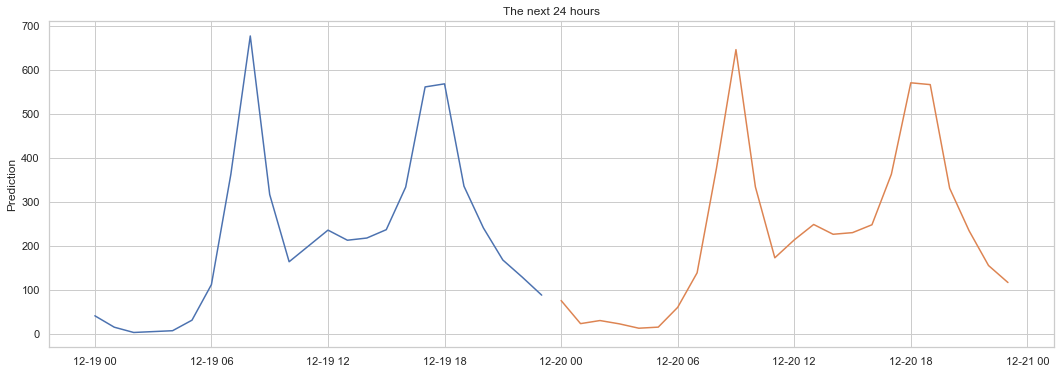

In [99]:
#To similulate future values, seaborn line plot is used. Next 24 hours is marked in orange 
#The prediction is not accurate during the late and early hours. The median hours look ok. Primarily due to lack of data
#Reduced seasonality in the data
sns.set() 
sns.set_style("whitegrid") 
plt.figure(figsize=(18,6))
sns.lineplot(x=df_act_final.index, y = df_act_final)
sns.lineplot(x=df_pred_final.index, y = df_pred_final)
plt.title("The next 24 hours")